# Homework original system: Word similarity

In [14]:
__author__ = "Pierre Jaumier"
__version__ = "CS224u, Stanford, Fall 2020"

`VSM` = Vector Space-Model

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import csv
import itertools
from scipy.stats import spearmanr
from IPython.display import display
import numpy as np
import os
import pandas as pd
import vsm
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from hw1_utils import *

In [17]:
exbd = wordsim353_reader()
next(exbd)
next(exbd)
next(exbd)
next(exbd)
next(exbd)
next(exbd)


('computer', 'internet', -7.58)

In [20]:
imdb5 = pd.read_csv(
    os.path.join(VSM_HOME, 'imdb_window5-scaled.csv.gz'), index_col=0)
imdb20 = pd.read_csv(
    os.path.join(VSM_HOME, 'imdb_window20-flat.csv.gz'), index_col=0)
giga5 = pd.read_csv(
    os.path.join(VSM_HOME, 'giga_window5-scaled.csv.gz'), index_col=0)
giga20 = pd.read_csv(
    os.path.join(VSM_HOME, 'giga_window20-flat.csv.gz'), index_col=0)

In [27]:
giga20.shape

(5000, 5000)

In [31]:
count_dfs = {'imdb5':imdb5, 'imdb20':imdb20, 'giga5':giga5, 'giga20':giga20}

## Baseline PPMI

In [25]:
for name, count_df in count_dfs.items():
    df_pmi = vsm.pmi(count_df)
    #display(full_word_similarity_evaluation(df_pmi))
    series = full_word_similarity_evaluation(df_pmi)
    print(df_name, '\t', series['Macro-average'])

imdb5 	 0.4763634758188182
imdb20 	 0.3539225011698424
giga5 	 0.4913448227592214
giga20 	 0.4185795186023304


## Baseline PPMI - LSA

In [32]:
for name, count_df in count_dfs.items():
    df_pmi = vsm.pmi(count_df)
    for k in [10, 100, 500, 1000]:
        df_lsa = vsm.lsa(df_pmi, k)
        series = full_word_similarity_evaluation(df_lsa)
        print(name, '\t', k, '\t', series['Macro-average'])

imdb5 	 10 	 0.3499086816105383
imdb5 	 100 	 0.5001466969819722
imdb5 	 500 	 0.5012871391776688
imdb5 	 1000 	 0.49201902661763325
imdb20 	 10 	 0.3029824559073233
imdb20 	 100 	 0.41269367060285733
imdb20 	 500 	 0.3759561261576586
imdb20 	 1000 	 0.356496703469767
giga5 	 10 	 0.3676894732477247
giga5 	 100 	 0.48408884763516785
giga5 	 500 	 0.5048935638458103
giga5 	 1000 	 0.501073937148383
giga20 	 10 	 0.34650895486444905
giga20 	 100 	 0.4183537479783744
giga20 	 500 	 0.4262144685093633
giga20 	 1000 	 0.42349824246101814


## t-test reweighting

In [35]:
for name, count_df in count_dfs.items():
    df_ttest = ttest(count_df)
    series = full_word_similarity_evaluation(df_ttest)
    print(name, '\t', series['Macro-average'])

imdb5 	 0.38750044552433094
imdb20 	 0.4086524279468504
giga5 	 0.39689033014903685
giga20 	 0.4439572029666641


### Gigaword with GloVe [0.5 points]

Can GloVe improve over the PPMI-based baselines we explored above? To begin to address this question, let's run GloVe and see how performance on our task changes throughout the optimization process.

__Your task__: write a function `run_glove_wordsim_evals` that does the following:

1. Has a parameter `n_runs` with default value `5`.

1. Reads in `data/vsmdata/giga_window5-scaled.csv.gz`.

1. Creates a `TorchGloVe` instance with `warm_start=True`, `max_iter=50`, and all other parameters set to their defaults.

1. `n_runs` times, calls `fit` on your model and, after each, runs `full_word_similarity_evaluation` with default keyword parameters, extract the 'Macro-average' score, and add that score to a list.

1. Returns the list of scores created.

The trend should give you a sense for whether it is worth running GloVe for more iterations.

Some implementation notes:

* `TorchGloVe` will accept and return `pd.DataFrame` instances, so you shouldn't need to do any type conversions.

* Performance will vary a lot for this function, so there is some uncertainty in the testing, but `run_glove_wordsim_evals` will at least check that you wrote a function with the right general logic.

In [36]:
from torch_glove import simple_example
simple_example()

Finished epoch 62 of 1000; error is 8.9993381500244143

TorchGloVe(
	batch_size=1028,
	max_iter=1000,
	eta=0.001,
	optimizer_class=<class 'torch.optim.adam.Adam'>,
	l2_strength=0,
	gradient_accumulation_steps=1,
	max_grad_norm=None,
	validation_fraction=0.1,
	early_stopping=False,
	n_iter_no_change=10,
	warm_start=False,
	tol=1e-05,
	embed_dim=2,
	alpha=0.75,
	xmax=100)


Finished epoch 1000 of 1000; error is 0.22686529159545898


Learned vectors:
[[2.4587748  0.04361401]
 [1.3996142  2.9031525 ]
 [1.2889156  2.0157218 ]
 [0.627825   1.7479807 ]]
We expect the dot product of learned vectors to be proportional to the log co-occurrence probs. Let's see how close we came:
Pearson's R: 0.44608053298268946 


0.44608053298268946

In [37]:
def run_glove_wordsim_evals(n_runs=5):

    from torch_glove import TorchGloVe
    X = pd.read_csv(os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)
    mod = TorchGloVe(warm_start=True, max_iter=50)
    results = []
    for run in range(n_runs):
        G = mod.fit(X)
        series = full_word_similarity_evaluation(G)
        results.append(series['Macro-average'])
    return results

In [38]:
def test_run_small_glove_evals(data):
    """`data` should be the return value of `run_glove_wordsim_evals`"""
    assert isinstance(data, list), \
        "`run_glove_wordsim_evals` should return a list"
    assert all(isinstance(x, float) for x in data), \
        ("All the values in the list returned by `run_glove_wordsim_evals` "
         "should be floats.")

In [39]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    glove_scores = run_glove_wordsim_evals()
    print(glove_scores)
    test_run_small_glove_evals(glove_scores)

Finished epoch 50 of 50; error is 2587871.18755

[0.0029026761649535203, 0.006793289047001877, 0.014338311352238975, 0.02657783507573257, 0.04640737043398835]


Le coefficient de Spearman augmente, donc nos observations sont plus similaires aux résultats souhaités (degrés de similarité en paires de mots)  
Par contre on est loin des valeurs obtenues avec ppmi et ppmi_lsa (essai à suivre avec 20 runs)  
the Spearman correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) 

In [40]:
glove_scores = run_glove_wordsim_evals(n_runs=20)
print(glove_scores)

Finished epoch 50 of 50; error is 844641.4531255

[0.0032487588527864418, 0.006856168461065987, 0.015825893796968547, 0.030936115864081258, 0.05344827882676786, 0.07937041558682159, 0.11107625424218111, 0.15604099781857408, 0.19910988485105555, 0.23421115157698394, 0.2614498660425167, 0.28276753725641324, 0.3009137402769376, 0.31630148172130756, 0.32940416971640607, 0.3401503298980795, 0.34906904587537396, 0.3555732601651972, 0.35991849973249923, 0.3630324058048463]


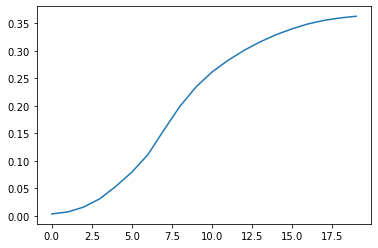

In [41]:
import matplotlib.pyplot as plt
plt.plot(glove_scores)

### Dice coefficient [0.5 points]

Implement the Dice coefficient for real-valued vectors, as

$$
\textbf{dice}(u, v) = 
1 - \frac{
  2 \sum_{i=1}^{n}\min(u_{i}, v_{i})
}{
    \sum_{i=1}^{n} u_{i} + v_{i}
}$$
 
You can use `test_dice_implementation` below to check that your implementation is correct.

In [42]:
def dice(u, v):
    return 1 - 2 * np.sum(np.minimum(u,v)) / np.sum(u + v)

In [43]:
def test_dice_implementation(func):
    """`func` should be an implementation of `dice` as defined above."""
    X = np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]])
    assert func(X[0], X[1]).round(5) == 0.80198
    assert func(X[1], X[2]).round(5) == 0.67568

In [44]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_dice_implementation(dice)

### t-test reweighting [2 points]



The t-test statistic can be thought of as a reweighting scheme. For a count matrix $X$, row index $i$, and column index $j$:

$$\textbf{ttest}(X, i, j) = 
\frac{
    P(X, i, j) - \big(P(X, i, *)P(X, *, j)\big)
}{
\sqrt{(P(X, i, *)P(X, *, j))}
}$$

where $P(X, i, j)$ is $X_{ij}$ divided by the total values in $X$, $P(X, i, *)$ is the sum of the values in row $i$ of $X$ divided by the total values in $X$, and $P(X, *, j)$ is the sum of the values in column $j$ of $X$ divided by the total values in $X$.

For this problem, implement this reweighting scheme. You can use `test_ttest_implementation` below to check that your implementation is correct. You do not need to use this for any evaluations, though we hope you will be curious enough to do so!

In [45]:
 X =  pd.DataFrame(np.array([
        [  4.,   4.,   2.,   100.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]))
X = X.to_numpy()
X_sum = X.sum()
P_j = X.sum(axis=0)/X_sum
P_i = X.sum(axis=1)/X_sum


In [46]:
def ttest(df):
    X = df.to_numpy()
    X_sum = X.sum()
    P_j = X.sum(axis=0) / X_sum
    P_i = X.sum(axis=1) / X_sum
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i,j] = (X[i,j] / X_sum - P_i[i] * P_j[j]) / np.sqrt(P_i[i] * P_j[j])
    return pd.DataFrame(X, index=df.index, columns=df.columns)

In [47]:
def test_ttest_implementation(func):
    """`func` should be `ttest`"""
    X = pd.DataFrame(np.array([
        [  4.,   4.,   2.,   0.],
        [  4.,  61.,   8.,  18.],
        [  2.,   8.,  10.,   0.],
        [  0.,  18.,   0.,   5.]]))
    actual = np.array([
        [ 0.33056, -0.07689,  0.04321, -0.10532],
        [-0.07689,  0.03839, -0.10874,  0.07574],
        [ 0.04321, -0.10874,  0.36111, -0.14894],
        [-0.10532,  0.07574, -0.14894,  0.05767]])
    predicted = func(X)
    #print(predicted)
    assert np.array_equal(predicted.round(5), actual)

In [48]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_ttest_implementation(ttest)

In [49]:
### t-test reweighting
giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
ttest_giga20 = ttest(giga20)
display(full_word_similarity_evaluation(ttest_giga20))

wordsim353         0.543632
mturk771           0.604347
simverb3500dev     0.205704
simverb3500test    0.140476
men                0.725626
Macro-average      0.443957
Name: Spearman r, dtype: float64

Le meilleur résultat pour l'instant!

### Enriching a VSM with subword information [2 points]

It might be useful to combine character-level information with word-level information. To help you begin asssessing this idea, this question asks you to write a function that modifies an existing VSM so that the representation for each word $w$ is the element-wise sum of $w$'s original word-level representation with all the representations for the n-grams $w$ contains. 

The following starter code should help you structure this and clarify the requirements, and a simple test is included below as well.

You don't need to write a lot of code; the motivation for this question is that the function you write could have practical value.

In [50]:
vsm.get_character_ngrams('mot', n=2)

['<w>m', 'mo', 'ot', 't</w>']

In [51]:
words = ['bon', 'bel']
df = pd.DataFrame([[1, 2], [3, 4]], index=words, columns=words)
df

,bon,bel
bon,1,2
bel,3,4


In [52]:
cf = vsm.ngram_vsm(df, n=2) # Character level VSM
cf

,bon,bel
<w>b,4,6
bo,1,2
on,1,2
n</w>,1,2
be,3,4
el,3,4
l</w>,3,4


In [53]:
vsm.character_level_rep('bon', cf, n=2)

array([ 7, 12])

Pour chaque mot on somme tous les bi-grammes au niveau des caractères  
Dans notre exemple cette somme est "associée" 10 fois avec `bon` et 16 fois avec `bel`  
Les bi-grammes très réccurents dans la matrice vont augmenter le poids du vecteur (ici `<w>b`)

In [54]:
def subword_enrichment(df, n=4):
    # 1. Use `vsm.ngram_vsm` to create a character-level
    # VSM from `df`, using the above parameter `n` to
    # set the size of the ngrams.

    cf = vsm.ngram_vsm(df, n) # Character level VSM


    # 2. Use `vsm.character_level_rep` to get the representation
    # for every word in `df` according to the character-level
    # VSM you created above.
    
    clr = [] # character level representation
    for w, _ in df.iterrows():
        clr.append(vsm.character_level_rep(w, cf, n))
    clr = np.array(clr)

    # 3. For each representation created at step 2, add in its
    # original representation from `df`. (This should use
    # element-wise addition; the dimensionality of the vectors
    # will be unchanged.)

    # subword enrichment :swe
    swe = df.to_numpy() + clr


    # 4. Return a `pd.DataFrame` with the same index and column
    # values as `df`, but filled with the new representations
    # created at step 3.

    return pd.DataFrame(swe, index=df.index, columns=df.columns)

In [55]:
def test_subword_enrichment(func):
    """`func` should be an implementation of subword_enrichment as
    defined above.
    """
    vocab = ["ABCD", "BCDA", "CDAB", "DABC"]
    df = pd.DataFrame([
        [1, 1, 2, 1],
        [3, 4, 2, 4],
        [0, 0, 1, 0],
        [1, 0, 0, 0]], index=vocab)
    expected = pd.DataFrame([
        [14, 14, 18, 14],
        [22, 26, 18, 26],
        [10, 10, 14, 10],
        [14, 10, 10, 10]], index=vocab)
    new_df = func(df, n=2)
    assert np.array_equal(expected.columns, new_df.columns), \
        "Columns are not the same"
    assert np.array_equal(expected.index, new_df.index), \
        "Indices are not the same"
    assert np.array_equal(expected.values, new_df.values), \
        "Co-occurrence values aren't the same"

In [56]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    test_subword_enrichment(subword_enrichment)

In [57]:
giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
swe_giga20 = subword_enrichment(giga20)
display(full_word_similarity_evaluation(swe_giga20))

wordsim353        -0.102895
mturk771          -0.006531
simverb3500dev     0.012539
simverb3500test    0.006986
men                0.064051
Macro-average     -0.005170
Name: Spearman r, dtype: float64

### Your original system [3 points]

This question asks you to design your own model. You can of course include steps made above (ideally, the above questions informed your system design!), but your model should not be literally identical to any of the above models. Other ideas: retrofitting, autoencoders, GloVe, subword modeling, ... 

Requirements:

1. Your code must operate on one or more of the count matrices in `data/vsmdata`. You can choose which subset of them; this is an important design feature of your system. __Other pretrained vectors cannot be introduced__.

1. Retrofitting is permitted.

1. Your code must be self-contained, so that we can work with your model directly in your homework submission notebook. If your model depends on external data or other resources, please submit a ZIP archive containing these resources along with your submission.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies. We also ask that you report the best score your system got during development, just to help us understand how systems performed overall.

In [58]:
# PLEASE MAKE SURE TO INCLUDE THE FOLLOWING BETWEEN THE START AND STOP COMMENTS:
#   1) Textual description of your system.
#   2) The code for your original system.
#   3) The score achieved by your system in place of MY_NUMBER.
#        With no other changes to that line.
#        You should report your score as a decimal value <=1.0
# PLEASE MAKE SURE NOT TO DELETE OR EDIT THE START AND STOP COMMENTS

# START COMMENT: Enter your system description in this cell.
# My peak score was: MY_NUMBER
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass

giga20 = pd.read_csv(os.path.join(VSM_HOME, "giga_window20-flat.csv.gz"), index_col=0)
x = subword_enrichment(giga20)
x = vsm.pmi(x)
#x = vsm.lsa(x, k=10)
#x = ttest(x) 0.18
#display(full_word_similarity_evaluation(x))

n_runs = 10
from torch_glove import TorchGloVe
#X = pd.read_csv(os.path.join(VSM_HOME, "giga_window5-scaled.csv.gz"), index_col=0)
mod = TorchGloVe(warm_start=True, max_iter=50)
results = []
for run in range(n_runs):
    G = mod.fit(x)
    G_lsa = vsm.lsa(G, k=10)
    series = full_word_similarity_evaluation(G_lsa)
    print(series['Macro-average'])


# STOP COMMENT: Please do not remove this comment.

Finished epoch 50 of 50; error is 43528.75439453125

0.10821805996116596


Finished epoch 50 of 50; error is 30335.89013671875

0.14847192304761944


Finished epoch 50 of 50; error is 21547.450683593755

0.16082345985385121


Finished epoch 50 of 50; error is 18068.280761718755

0.16584782210013793


Finished epoch 50 of 50; error is 16539.783447265625

0.17275752490216237


Finished epoch 50 of 50; error is 15738.956298828125

0.18012496625847577


Finished epoch 50 of 50; error is 15258.352539062525

0.18592604498960866


Finished epoch 50 of 50; error is 14940.821777343755

0.19189856469920447


Finished epoch 50 of 50; error is 14717.021728515625

0.19564005223363895


Finished epoch 50 of 50; error is 14551.838867187555

0.1985481278953166


In [59]:
series = full_word_similarity_evaluation(G)
print(series['Macro-average'])

0.35093707235233207


VSM: retrofitting

In [60]:
#G_retrofitted = os.path.join(PATH_TO_DATA, 'glove6B300d-retrofit-wn.csv.gz')
#import utils
G_retrofitted = pd.read_csv(os.path.join(PATH_TO_DATA, "glove6B300d-retrofit-wn.csv.gz"),
                           index_col=0)
#glove_dict = utils.glove2dict(os.path.join(PATH_TO_DATA, "glove6B300d-retrofit-wn.csv.gz"))

In [61]:
G_retrofitted.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [62]:
full_word_similarity_evaluation(G_retrofitted)

ValueError: Word 'misspend' is in the similarity dataset simverb3500dev but not in the DataFrame, making this evaluation ill-defined. Please switch to a DataFrame with an appropriate vocabulary.

## Bake-off [1 point]

For the bake-off, we will release two additional datasets. The announcement will go out on the discussion forum. We will also release reader code for these datasets that you can paste into this notebook. You will evaluate your custom model $M$ (from the previous question) on these new datasets using `full_word_similarity_evaluation`. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.

The cells below this one constitute your bake-off entry.

People who enter will receive the additional homework point, and people whose systems achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
# Enter your bake-off assessment code into this cell.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your code in the scope of the above conditional.
    ##### YOUR CODE HERE


In [ ]:
# On an otherwise blank line in this cell, please enter
# your "Macro-average" value as reported by the code above.
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.
if 'IS_GRADESCOPE_ENV' not in os.environ:
    pass
    # Please enter your score in the scope of the above conditional.
    ##### YOUR CODE HERE
